In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
import scipy
#from numpy.linalg import svd


import warnings
warnings.filterwarnings("ignore")


In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), 'Documents/git/Xct'))

    from scTenifoldXct.main import *
    import scTenifoldXct.dNN as dNN    
    import scTenifoldXct.visualization as vis
    
except ImportError:
    print('Module not found')

In [3]:
ada = sc.read_h5ad("../data/LS_processed.h5ad")
ada

AnnData object with n_obs × n_vars = 5011 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    layers: 'log1p', 'raw'

## create a Xct_metrics obj:

In [4]:
skin = Xct_metrics(ada)
type(skin)

scTenifoldXct.main.Xct_metrics

In [5]:
skin.LRs.head()

,ligand,receptor
0,BDNF,TRPC1
1,CXCL12,GNAI2
2,PF4,GNAI2
3,EPOR,TRPC3
4,EPOR,EPO


In [6]:
skin._genes_index_DB

array([[1194,    0],
       [2920,    0],
       [   0,    0],
       ...,
       [   0,    0],
       [   0,    0],
       [   0,    0]])

In [7]:
ada.var_names[1194-1] #check

'BDNF'

918 (intervals for fit) / 3000 (filtered -Inf) / 3000 (original) features for the fit


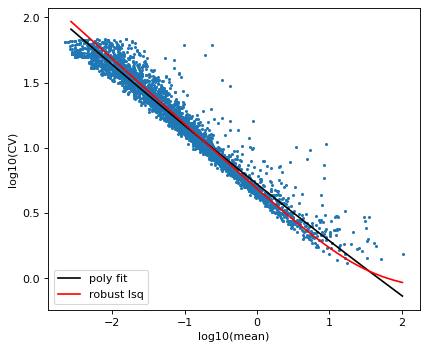

array([ 0.048889  , -0.07626458, -0.02784309, ...,  0.78019458,
        0.59314723,  0.22144539])

In [8]:
skin.chen2016_fit(ada, plot = True, verbose = True)

## create a Xct obj with GRN building:

In [9]:
obj1 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', mode = 'full', verbose = True)

print(obj1)

init an Xct object for interactions from Inflam. FIB (484) to Inflam. DC (81)...
loading GRNs...
building correspondence...
init completed.

Xct object for interactions from Inflam. FIB (484) to Inflam. DC (81)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [10]:
df1 = obj1.fill_metric()
df1

,ligand,receptor,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
18,IGF1,NTRK2,0.029522,0.024446,0.067410,0.027285,2.283343,1.116142,8.794479,6.757026,0.156436,-0.338065
28,AREG,NTRK2,0.003443,0.024446,0.005726,0.027285,1.663072,1.116142,21.977261,6.757026,-0.221117,-0.338065
33,FGF2,NTRK2,0.076530,0.024446,0.142827,0.027285,1.866276,1.116142,4.938230,6.757026,-0.075862,-0.338065
35,FGF7,NTRK2,0.449156,0.024446,0.835224,0.027285,1.859543,1.116142,2.034720,6.757026,0.023099,-0.338065
53,BDNF,NTRK2,0.009386,0.024446,0.016305,0.027285,1.737234,1.116142,13.604940,6.757026,-0.094830,-0.338065
...,...,...,...,...,...,...,...,...,...,...,...,...
7884,LAMB1,SV2B,0.192922,0.015761,0.356617,0.019873,1.848509,1.260899,3.095425,8.944272,-0.019347,-0.338065
7890,LAMC3,SV2B,0.343355,0.015761,0.610706,0.019873,1.778645,1.260899,2.276004,8.944272,-0.046932,-0.338065
7894,LAMB2,SV2B,1.027162,0.015761,1.343443,0.019873,1.307918,1.260899,1.128420,8.944272,-0.030466,-0.338065
8023,FSTL1,DIP2A,1.154967,0.066773,1.490066,0.086209,1.290138,1.291068,1.056898,4.397163,0.014484,-0.313400


## permutation mode:

In [ ]:
# np.random.seed(1)

# orig_score = np.asarray(obj1.score(method=1))
# pmt_scores = scores(ada, obj1, method = 1, a = 0.8, n = 100)

# enriched, pvals, counts = pmt_test(orig_score, pmt_scores)
# #enriched, counts

# df_enriched = df1.iloc[enriched, :]
# print('Total enriched:', len(df_enriched))
# df_enriched

## mode 'full':

In [11]:
counts_np1 = get_counts_np(obj1)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape

(2, (3000, 484), (3000, 81))

In [12]:
projections, losses = dNN.train_and_project(counts_np1, obj1._w, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=484, out_features=124, bias=True)
  (linear2): Linear(in_features=124, out_features=31, bias=True)
  (linear3): Linear(in_features=31, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
1 5230.7421875
100 761.1779174804688
200 568.0203857421875
300 564.5523071289062
400 562.7119140625
500 561.2339477539062
600 560.3892211914062
700 559.9523315429688
800 559.67041015625
900 559.482177734375
1000 559.3536376953125


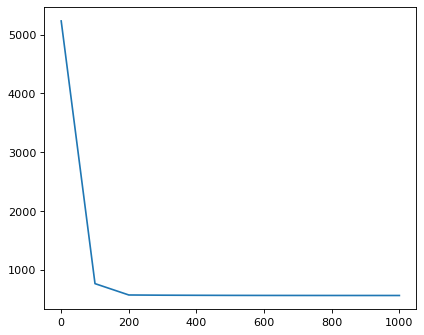

In [13]:
plot_nn_loss(losses)

In [14]:
obj1._net_A.shape, obj1._net_B.shape, obj1._w.shape #check

((3000, 3000), (3000, 3000), (6000, 6000))

In [15]:
w12 = obj1._w[:obj1._net_A.shape[0], obj1._net_A.shape[1]:]

np.mean(w12)  #check

1.0002169791476765

In [16]:
#selected LR pairs
candidates = get_candidates(df1)
print(len(candidates))
candidates[:5]

160


['IGF1_NTRK2', 'AREG_NTRK2', 'FGF2_NTRK2', 'FGF7_NTRK2', 'BDNF_NTRK2']

In [ ]:
# np.savetxt("./data/skin_projections_pair.csv", projections, delimiter="\t")

# projections = np.genfromtxt("./data/skin_projections_pair.csv", delimiter="\t")

In [17]:
df_nn = nn_aligned_dist(obj1, projections)
df_nn

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
ZFP36L1_ADAM19,"(15, 897)",0.000002,1,1.293849e+02
TSC22D3_CCL22,"(913, 2937)",0.000004,2,2.180142e+02
HAS2_JUNB,"(1092, 2747)",0.000004,3,1.047737e+02
RNF213_C15orf48,"(1013, 2940)",0.000005,4,1.481871e+02
TSC22D3_SAT1,"(913, 2397)",0.000005,5,2.222929e+02
...,...,...,...,...
SULT1A2_C1orf228,"(183, 1338)",0.029943,8999996,1.161586e-47
SULT1A2_TSPAN11,"(183, 1339)",0.029943,8999997,1.161586e-47
SULT1A2_ZNF37BP,"(183, 1340)",0.029943,8999998,1.161586e-47
SULT1A2_CMTM4,"(183, 1317)",0.029943,8999999,1.161586e-47


In [ ]:
#df_nn_to_output = df_nn.iloc[:1000, :]
#df_nn_to_output.to_csv('distances_nn.csv')

[[ 1.         -0.15600288]
 [-0.15600288  1.        ]]


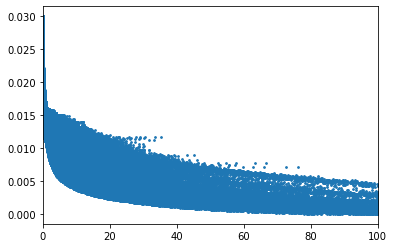

In [18]:
#check corr
select = df_nn['correspondence_score'] != 0
nX = np.asarray(df_nn['correspondence_score'][select])
nY = np.asarray(df_nn['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
# df_nn_filtered = df_nn.loc[candidates]
# len(df_nn_filtered)

In [19]:
df_nn_filtered = filtered_nn_aligned_dist(df_nn, candidates)
df_nn_filtered.head()

manifold aligned # of L-R pairs: 160


,idx,dist,rank,correspondence_score,rank_filtered
VCAM1_ITGB2,"(1458, 491)",0.000539,7557,65.192753,1
CCL2_CXCR4,"(2820, 2548)",0.000661,9186,220.004351,2
CXCL12_CXCR4,"(2919, 2548)",0.000692,9611,229.953224,3
CCL2_CCR7,"(2820, 2138)",0.000764,10634,311.432610,4
CXCL12_CCR7,"(2919, 2138)",0.000795,11047,325.515984,5


In [20]:
df_enriched = chi2_test(df_nn, candidates = candidates)

df_enriched


Total enriched: 12 / 9000000


,idx,dist,rank,correspondence_score,p_val,enriched_rank
VCAM1_ITGB2,"(1458, 491)",0.000539,7557,65.192753,0.017105,1
CCL2_CXCR4,"(2820, 2548)",0.000661,9186,220.004351,0.021006,2
CXCL12_CXCR4,"(2919, 2548)",0.000692,9611,229.953224,0.021984,3
CCL2_CCR7,"(2820, 2138)",0.000764,10634,311.432610,0.024264,4
CXCL12_CCR7,"(2919, 2138)",0.000795,11047,325.515984,0.025242,5
CXCL14_CXCR4,"(2994, 2548)",0.000957,13383,393.954971,0.030399,6
CCL19_CXCR4,"(2993, 2548)",0.000981,13720,419.748050,0.031159,7
CXCL1_CCR7,"(2596, 2138)",0.001032,14426,75.120212,0.032770,8
CXCL14_CCR7,"(2994, 2138)",0.001060,14805,557.672720,0.033671,9
CCL19_CCR7,"(2993, 2138)",0.001084,15105,594.184752,0.034434,10


In [21]:
df_enriched.to_excel('LS_skin_result.xlsx')

#### GSEA:

In [22]:
genelist = get_genelist(df_enriched)
len(genelist)

10

In [24]:
import gseapy as gp

enr = gp.enrichr(gene_list= list(genelist),
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [25]:
enr.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cellular response to cytokine stimulus (GO:007...,9/482,2.493185e-14,1.328868e-11,0,0,371.359408,11631.953443,CXCL12;VCAM1;ITGB2;CXCR4;CCL2;CCR7;CXCL1;CCL19...
1,GO_Biological_Process_2021,inflammatory response (GO:0006954),7/230,2.828569e-12,7.538138e-10,0,0,206.829596,5499.857509,ITGB2;CXCR4;CCL2;CCR7;CXCL1;CCL19;TNF
2,GO_Biological_Process_2021,cytokine-mediated signaling pathway (GO:0019221),7/621,2.976971e-09,4.192831e-07,0,0,73.633008,1445.589680,CXCL12;VCAM1;ITGB2;CCL2;CXCL1;CCL19;TNF
3,GO_Biological_Process_2021,negative regulation of dendritic cell apoptoti...,3/7,3.146590e-09,4.192831e-07,0,0,2141.357143,41921.234283,CXCL12;CCR7;CCL19
4,GO_Biological_Process_2021,chemokine-mediated signaling pathway (GO:0070098),4/56,1.142758e-08,1.154127e-06,0,0,255.615385,4674.498811,CXCL12;CCL2;CXCL1;CCL19


In [26]:
enr.results.to_excel('LS_enrichr.xlsx')

#### visualization:

In [27]:
Xct.add_names_to_nets(obj1)

completed.


In [28]:
targets = vis.get_Xct_pairs(df_enriched)
targets

(['VCAM1', 'ITGB2'],
 ['CCL2', 'CXCR4'],
 ['CXCL12', 'CXCR4'],
 ['CCL2', 'CCR7'],
 ['CXCL12', 'CCR7'],
 ['CXCL14', 'CXCR4'],
 ['CCL19', 'CXCR4'],
 ['CXCL1', 'CCR7'],
 ['CXCL14', 'CCR7'],
 ['CCL19', 'CCR7'],
 ['CXCL1', 'CXCR4'],
 ['CCL2', 'TNF'])

identified 217 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 32, # of edges: 40



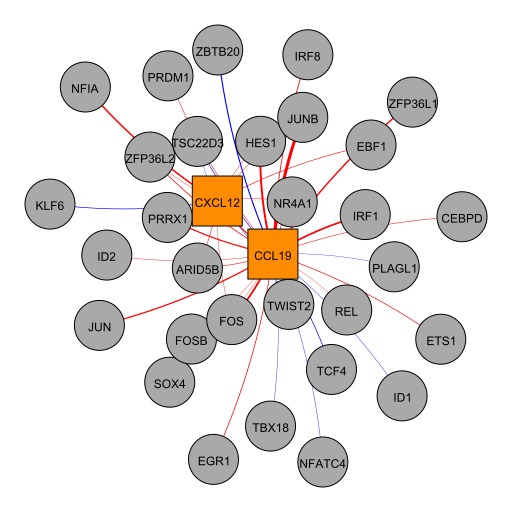

In [29]:
vis.plot_pcNet(obj1, view='sender', gene_names=['CCL19', 'CXCL12'], top_edges=40, show = True, verbose = True)

identified 217 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 31, # of edges: 40



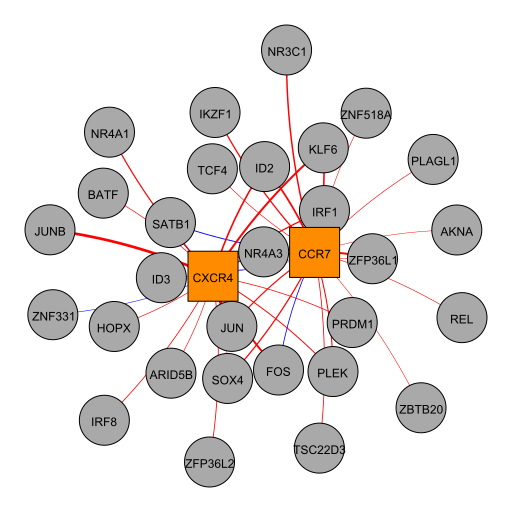

In [30]:
vis.plot_pcNet(obj1, view='receiver', gene_names=['CCR7', 'CXCR4'], top_edges=40, show = True, verbose = True)

identified 217 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 32, # of edges: 40

identified 217 TF(s) along with 2 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 31, # of edges: 40

graphs merged: 
# of nodes: 63, # of edges: 80

edge from CCL19 to CCR7 added
edge from CXCL12 to CXCR4 added


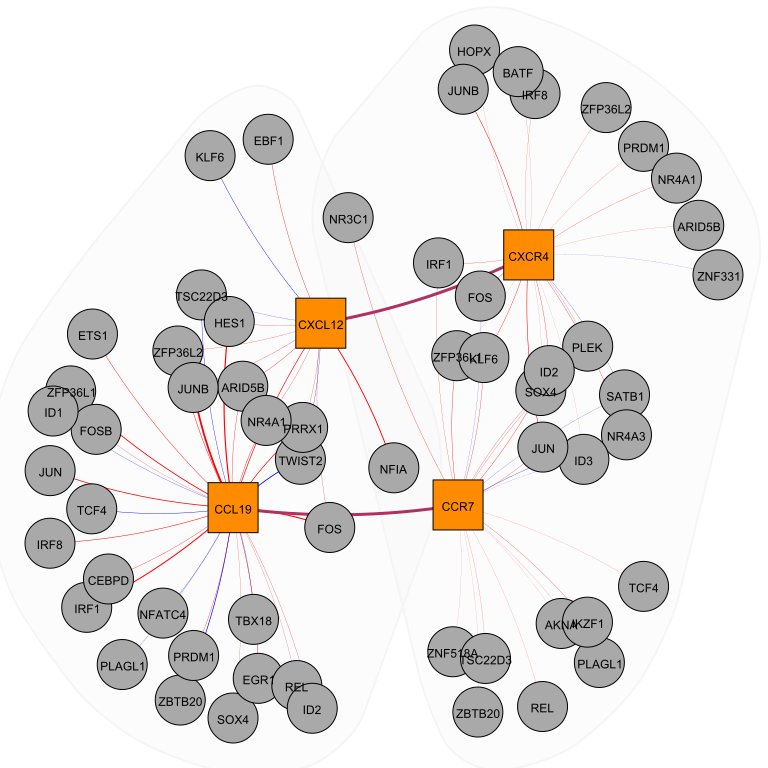

In [31]:
g1 = vis.plot_pcNet(obj1, view='sender', gene_names=['CCL19', 'CXCL12'], top_edges=40, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', gene_names=['CCR7', 'CXCR4'], top_edges=40, show = False, verbose = True)
vis.plot_XNet(g1, g2, Xct_pair = [('CCL19', 'CCR7'), ('CXCL12', 'CXCR4')], verbose = True)

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from VCAM1 to ITGB2 added


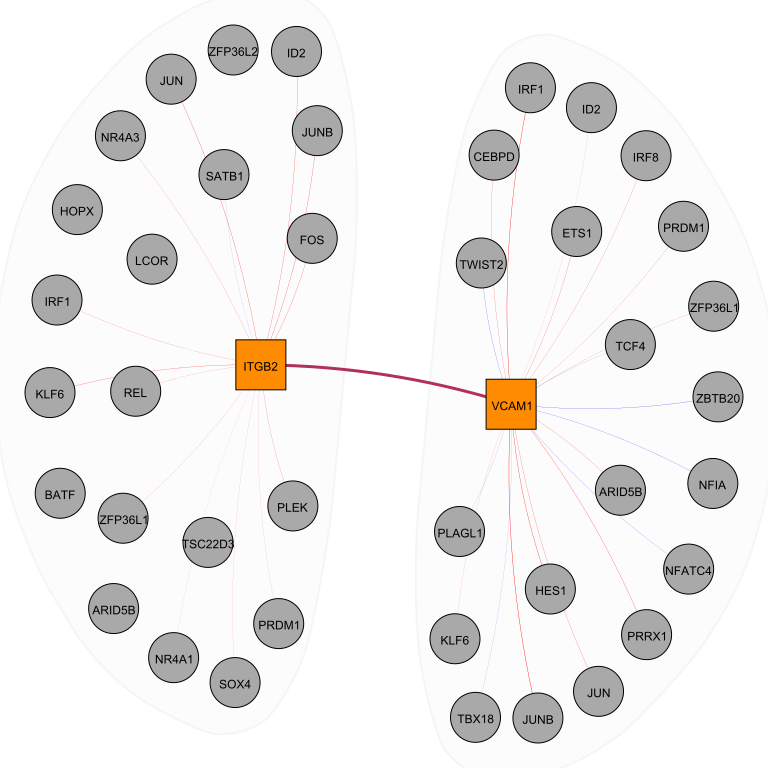

In [32]:
g1 = vis.plot_pcNet(obj1, view='sender', gene_names=[targets[0][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', gene_names=[targets[0][1]], top_edges=20, show = False, verbose = True)
vis.plot_XNet(g1, g2, Xct_pair = [targets[0]], verbose = True)

## mode 'comb':

In [ ]:
obj2 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', mode = 'comb', verbose = True)

In [ ]:
w12 = obj2._w[:obj2._net_A.shape[0], obj2._net_A.shape[1]:]

np.mean(w12)  

In [ ]:
projections2, losses2 = dNN.train_and_project(counts_np1, obj2._w, dim = 2, steps = 1000, lr = 0.01)


In [ ]:
plot_nn_loss(losses2)

In [ ]:
# np.savetxt("./data/skin_projections_comb.csv", projections2, delimiter="\t")

# projections2 = np.genfromtxt("./data/skin_projections_comb.csv", delimiter="\t")

In [ ]:
df_nn2 = nn_aligned_dist(obj2, projections2)
df_nn2.head()

In [ ]:
#check corr
select = df_nn2['correspondence_score'] != 0
nX = np.asarray(df_nn2['correspondence_score'][select])
nY = np.asarray(df_nn2['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
#df_nn_to_output2 = df_nn2.iloc[:1000, :]
#df_nn_to_output2.to_csv('distances_nn2.csv')

In [ ]:
df_enriched2 = chi2_test(df_nn2, df = 3, pval = 0.05, FDR = True, candidates = candidates)
df_enriched2

## mode pairs:

In [ ]:
obj3 = Xct(ada, 'Inflam. FIB', 'Inflam. DC', build_GRN = False, pcNet_name = 'skin_net', 
           mode = 'pairs', verbose = True)

In [ ]:
w12 = obj3._w[:obj3._net_A.shape[0], obj3._net_A.shape[1]:]

np.mean(w12)  

In [ ]:
projections3, losses3 = dNN.train_and_project(counts_np1, obj3._w, dim = 2, steps = 1000, lr = 0.001)

In [ ]:
plot_nn_loss(losses3)

In [ ]:
# np.savetxt("./data/skin_projections_all.csv", projections3, delimiter="\t")

# projections3 = np.genfromtxt("./data/skin_projections_all.csv", delimiter="\t")

In [ ]:
df_nn3 = nn_aligned_dist(obj3, projections3)
df_nn3.head()

In [ ]:
#check corr
select = df_nn3['correspondence_score'] != 0
nX = np.asarray(df_nn3['correspondence_score'][select])
nY = np.asarray(df_nn3['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
#df_nn_to_output3 = df_nn3.iloc[:20000, :]
#df_nn_to_output3.to_csv('distances_nn3.csv')

In [ ]:
df_enriched3 = chi2_test(df_nn3, df = 3, pval = 0.05, FDR = True, candidates = candidates)

df_enriched3

### Inflam.DC to Inflam. TC:

In [33]:
# obj11 = Xct(ada, 'Inflam. DC', 'Inflam. TC', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_DC2TC_LS', mode = 'full', verbose = True)

obj11 = Xct(ada, 'Inflam. DC', 'Inflam. TC', build_GRN = False,
           pcNet_name = 'net_DC2TC_LS', mode = 'full', verbose = True)
print(obj11)

init an Xct object for interactions from Inflam. DC (81) to Inflam. TC (266)...
loading GRNs...
building correspondence...
init completed.

Xct object for interactions from Inflam. DC (81) to Inflam. TC (266)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [34]:
df11 = obj11.fill_metric()
df11

,ligand,receptor,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
18,IGF1,NTRK2,0.015782,0.188672,0.019926,0.382669,1.262558,2.028219,8.944272,3.278712,-0.338065,-0.067928
28,AREG,NTRK2,0.302649,0.188672,0.695448,0.382669,2.297869,2.028219,2.755452,3.278712,0.082755,-0.067928
40,EFNA1,NTRK2,0.040046,0.188672,0.071560,0.382669,1.786941,2.028219,6.679971,3.278712,-0.060825,-0.067928
56,VEGFA,NTRK2,0.264259,0.188672,0.576541,0.382669,2.181724,2.028219,2.873324,3.278712,0.190714,-0.067928
198,CD8A,LAT,0.016989,0.746377,0.023090,1.278990,1.359118,1.713596,8.944272,1.515218,-0.338065,-0.006231
...,...,...,...,...,...,...,...,...,...,...,...,...
7370,CXCL8,LPAR2,0.834715,0.057883,2.376544,0.159946,2.847133,2.763275,1.846864,6.909344,0.391188,0.082742
7703,IL32,PTGER1,1.086030,0.014364,1.565225,0.054677,1.441235,3.806483,1.151984,16.278821,0.062660,0.219659
7882,PCSK1N,GPR171,0.015782,0.582902,0.019926,1.139179,1.262558,1.954321,8.944272,1.831049,-0.338065,-0.010688
7920,CLEC2D,KLRB1,0.077279,0.373006,0.140790,1.048742,1.821834,2.811599,4.855375,2.745485,0.041242,0.323326


In [35]:
#selected LR pairs
candidates11 = get_candidates(df11)
print(len(candidates11))
candidates11[:5]

231


['IGF1_NTRK2', 'AREG_NTRK2', 'EFNA1_NTRK2', 'VEGFA_NTRK2', 'CD8A_LAT']

In [36]:
counts_np11 = get_counts_np(obj11)
len(counts_np11), counts_np11[0].shape, counts_np11[1].shape

(2, (3000, 81), (3000, 266))

In [37]:
projections11, losses11 = dNN.train_and_project(counts_np11, obj11._w, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=81, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=266, out_features=92, bias=True)
  (linear2): Linear(in_features=92, out_features=23, bias=True)
  (linear3): Linear(in_features=23, out_features=2, bias=True)
)
1 5802.9716796875
100 623.4925537109375
200 608.707275390625
300 612.8707275390625
400 604.0362548828125
500 601.3087158203125
600 599.7100219726562
700 598.7650756835938
800 598.1671142578125
900 597.7393798828125
1000 597.3453979492188


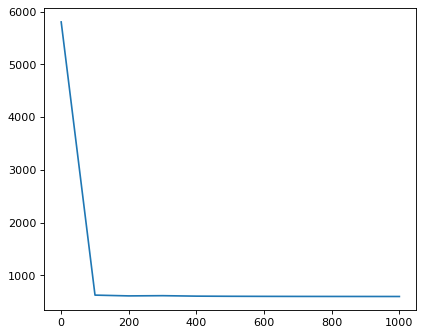

In [38]:
plot_nn_loss(losses11)

In [39]:
df_nn11 = nn_aligned_dist(obj11, projections11)
df_nn11

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
KLF6_LIMD2,"(2139, 425)",0.000002,1,1.136353e+02
PLEK_CD27,"(1337, 2525)",0.000003,2,1.054318e+02
BTG1_CD27,"(1978, 2525)",0.000003,3,2.042175e+02
GADD45B_LIMD2,"(2379, 425)",0.000003,4,9.317509e+01
ITGB2_FOS,"(491, 2946)",0.000004,5,6.190859e+01
...,...,...,...,...
BCL2L15_SORCS2,"(1, 201)",0.030219,8999996,1.419132e-47
BCL2L15_LTBP2,"(1, 200)",0.030219,8999997,1.419132e-47
BCL2L15_SFRP4,"(1, 2582)",0.030219,8999998,1.419132e-47
BCL2L15_GARNL3,"(1, 173)",0.030219,8999999,1.419132e-47


[[ 1.         -0.17499127]
 [-0.17499127  1.        ]]


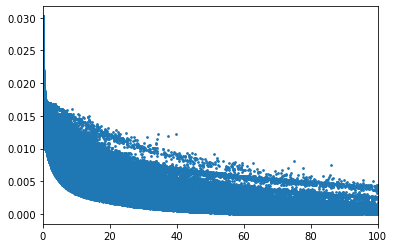

In [40]:
#check corr
select = df_nn11['correspondence_score'] != 0
nX = np.asarray(df_nn11['correspondence_score'][select])
nY = np.asarray(df_nn11['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [41]:
df_enriched11 = chi2_test(df_nn11, candidates = candidates11)

df_enriched11


Total enriched: 11 / 9000000


,idx,dist,rank,correspondence_score,p_val,enriched_rank
S100B_TNF,"(2883, 2815)",0.000042,569,65.653715,0.001354,1
CCL22_CXCR4,"(2937, 2548)",0.000044,605,208.066379,0.001401,2
CCL17_CXCR4,"(2990, 2548)",0.000048,699,284.506940,0.001536,3
S100A8_CD69,"(2766, 2943)",0.000705,13056,108.696947,0.022474,4
CCL17_CXCR6,"(2990, 509)",0.000722,13347,189.769742,0.023018,5
CCL22_CXCR6,"(2937, 509)",0.000728,13453,138.782917,0.023199,6
HLA-DMA_CD74,"(2065, 2991)",0.000903,16717,175.272493,0.028771,7
CXCL8_CXCR4,"(2941, 2548)",0.000985,18192,65.741994,0.031407,8
CCL17_CCR6,"(2990, 2164)",0.001354,24891,142.785056,0.043146,9
CCL22_CCR6,"(2937, 2164)",0.001360,24973,104.421951,0.043326,10


In [42]:
df_enriched11.to_excel('LS_skin_DC2T.xlsx')

#### GSEA:

In [43]:
genelist11 = get_genelist(df_enriched11)
len(genelist11)

13

In [44]:
import gseapy as gp

enr11 = gp.enrichr(gene_list= list(genelist11),
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [45]:
enr11.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,inflammatory response (GO:0006954),6/230,3.475990e-09,0.000002,0,0,75.623724,1472.952503,CXCL8;CCL22;CXCR4;TNF;CCL17;S100A8
1,GO_Biological_Process_2021,neutrophil chemotaxis (GO:0030593),4/70,9.604199e-08,0.000016,0,0,134.148148,2167.630214,CXCL8;CCL22;CCL17;S100A8
2,GO_Biological_Process_2021,granulocyte chemotaxis (GO:0071621),4/73,1.138867e-07,0.000016,0,0,128.296296,2051.209072,CXCL8;CCL22;CCL17;S100A8
3,GO_Biological_Process_2021,neutrophil migration (GO:1990266),4/77,1.413948e-07,0.000016,0,0,121.242009,1912.193830,CXCL8;CCL22;CCL17;S100A8
4,GO_Biological_Process_2021,second-messenger-mediated signaling (GO:0019932),4/89,2.540091e-07,0.000024,0,0,104.062745,1580.285988,CXCL8;CXCR4;CXCR6;CCR6


In [46]:
enr11.results.to_excel('LS_enrichr_DC2T.xlsx')

#### visualization:

In [47]:
Xct.add_names_to_nets(obj11)

completed.


In [48]:
targets = vis.get_Xct_pairs(df_enriched11)
targets

(['S100B', 'TNF'],
 ['CCL22', 'CXCR4'],
 ['CCL17', 'CXCR4'],
 ['S100A8', 'CD69'],
 ['CCL17', 'CXCR6'],
 ['CCL22', 'CXCR6'],
 ['HLA-DMA', 'CD74'],
 ['CXCL8', 'CXCR4'],
 ['CCL17', 'CCR6'],
 ['CCL22', 'CCR6'],
 ['TNF', 'NR3C1'])

identified 217 TF(s) along with 3 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 30



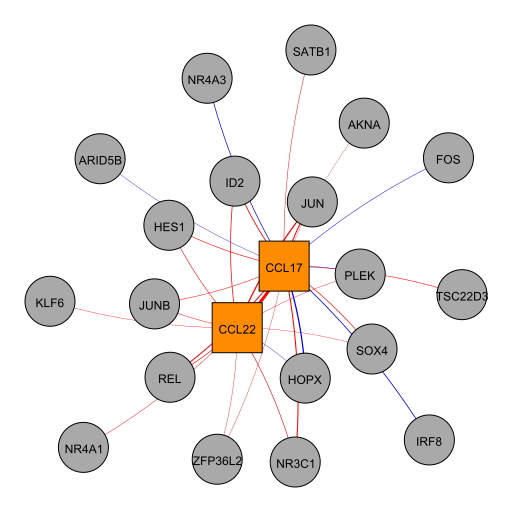

In [49]:
vis.plot_pcNet(obj11, view='sender', gene_names = [targets[1][0], targets[2][0], targets[5][0]], 
               top_edges=30, show = True, verbose = True)

identified 217 TF(s) along with 3 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 30

identified 217 TF(s) along with 3 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 25, # of edges: 30

graphs merged: 
# of nodes: 46, # of edges: 60

edge from CCL22 to CXCR4 added
edge from CCL17 to CXCR6 added
edge from CCL22 to CXCR6 added
graph saved as "LS_DC2T.png"


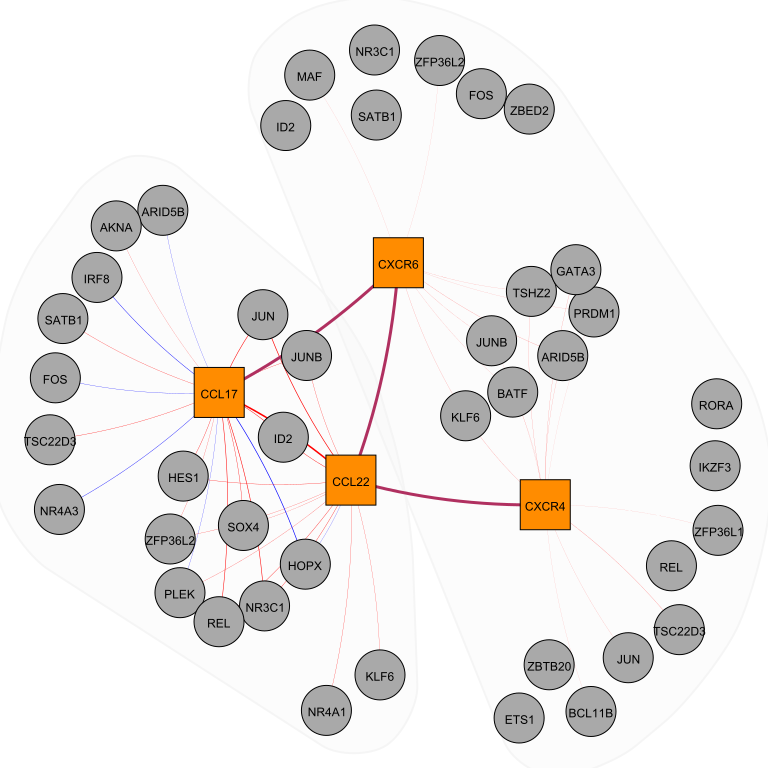

In [51]:
g1 = vis.plot_pcNet(obj11, view='sender', gene_names=[targets[1][0], targets[4][0], targets[5][0]], 
                    top_edges=30, show = False, verbose = True)
g2 = vis.plot_pcNet(obj11, view='receiver', gene_names=[targets[1][1], targets[4][1], targets[5][1]], 
                    top_edges=30, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[1], targets[4], targets[5]], verbose = True, saveas='LS_DC2T')